# Introduction

Since we have already analyzed all these datasets in the target countries section, we see that using the global dataset for all our modeling is the best option for a few reasons:

- it contains data for all the countries we are covering
- it has up to date data that includes the whole lifetime of the pandemic
- the individual countries datasets are not as complete in some cases
- a single dataset is arguably easier to work with compared to many
- the data is already clean and
- we have already confirmed the creadability of the data

### Objectives

our main objective is to see which one of our chosen 4 countries have handled the virus in a way that can be generalized to everyone as simple guidelines, the targeted countries are

- United States
- Germany
- Italy
- South Korea

# Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, GlobalMaxPooling1D, Bidirectional
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

%matplotlib inline

# supress annoying warning
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
df_confirmed = pd.read_csv("../input/covid-19/time_series_covid19_confirmed_global.csv")
df_deaths = pd.read_csv("../input/covid-19/time_series_covid19_deaths_global.csv")
df_reco = pd.read_csv("../input/covid-19/time_series_covid19_recovered_global.csv")

after reading in our dataset lets take a look at it by showing the first few countries for confirmed case, deaths, and recoveries

In [3]:
df_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,40626,40687,40768,40833,40937,41032,41145,41268,41334,41425
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,18250,18556,18858,19157,19445,19729,20040,20315,20634,20875
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,55357,55630,55880,56143,56419,56706,57026,57332,57651,57942
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,3811,4038,4038,4038,4325,4410,4517,4567,4665,4756
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,8582,8829,9026,9381,9644,9871,10074,10269,10558,10805


In [4]:
df_deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,1505,1507,1511,1514,1518,1523,1529,1532,1533,1536
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,465,469,473,477,480,487,493,499,502,509
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,1888,1897,1907,1914,1922,1931,1941,1949,1956,1964
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,63,69,69,69,72,72,72,73,75,75
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,260,265,267,268,270,271,275,275,279,284


In [5]:
df_reco.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,33831,34010,34023,34129,34150,34217,34237,34239,34258,34321
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,10395,10466,10548,10654,10705,10808,10893,11007,11097,11189
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,38618,38788,38932,39095,39273,39444,39635,39635,40014,40201
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,2470,2729,2729,2729,2957,3029,3144,3260,3377,3475
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,3305,3384,3461,3508,3530,3647,3693,3736,4107,4523


after taking a look at the data as a whole lets now get our target countries each in their own dataframes

In [6]:
us_confirmed = df_confirmed[df_confirmed["Country/Region"] == "US"]
us_deaths = df_deaths[df_deaths["Country/Region"] == "US"]
us_reco = df_reco[df_reco["Country/Region"] == "US"]

germany_confirmed = df_confirmed[df_confirmed["Country/Region"] == "Germany"]
germany_deaths = df_deaths[df_deaths["Country/Region"] == "Germany"]
germany_reco = df_reco[df_reco["Country/Region"] == "Germany"]

italy_confirmed = df_confirmed[df_confirmed["Country/Region"] == "Italy"]
italy_deaths = df_deaths[df_deaths["Country/Region"] == "Italy"]
italy_reco = df_reco[df_reco["Country/Region"] == "Italy"]

sk_confirmed = df_confirmed[df_confirmed["Country/Region"] == "Korea, South"]
sk_deaths = df_deaths[df_deaths["Country/Region"] == "Korea, South"]
sk_reco = df_reco[df_reco["Country/Region"] == "Korea, South"]

In [7]:
us_reco

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20
231,NaN,US,40.0,-100.0,0,0,0,0,0,0,...,3353056,3375427,3406656,3422878,3460455,3487666,3518140,3554336,3578452,3612478


with the current data structure shown above we cant do much so lets first convert it to a form that can used to make graphs or train a model

In [8]:
## structuring timeseries data
def confirmed_timeseries(df):
    df_series = pd.DataFrame(df[df.columns[4:]].sum(),columns=["confirmed"])
    df_series.index = pd.to_datetime(df_series.index,format = '%m/%d/%y')
    return df_series

def deaths_timeseries(df):
    df_series = pd.DataFrame(df[df.columns[4:]].sum(),columns=["deaths"])
    df_series.index = pd.to_datetime(df_series.index,format = '%m/%d/%y')
    return df_series

def reco_timeseries(df):
    # no index to timeseries conversion needed (all is joined later)
    df_series = pd.DataFrame(df[df.columns[4:]].sum(),columns=["recovered"])
    return df_series

In [9]:
us_con_series = confirmed_timeseries(us_confirmed)
us_dea_series = deaths_timeseries(us_deaths)
us_reco_series = reco_timeseries(us_reco)

germany_con_series = confirmed_timeseries(germany_confirmed)
germany_dea_series = deaths_timeseries(germany_deaths)
germany_reco_series = reco_timeseries(germany_reco)

italy_con_series = confirmed_timeseries(italy_confirmed)
italy_dea_series = deaths_timeseries(italy_deaths)
italy_reco_series = reco_timeseries(italy_reco)

sk_con_series = confirmed_timeseries(sk_confirmed)
sk_dea_series = deaths_timeseries(sk_deaths)
sk_reco_series = reco_timeseries(sk_reco)

In [10]:
# join all data frames for each county (makes it easier to graph and compare)

us_df = us_con_series.join(us_dea_series, how = "inner")
us_df = us_df.join(us_reco_series, how = "inner")

germany_df = germany_con_series.join(germany_dea_series, how = "inner")
germany_df = germany_df.join(germany_reco_series, how = "inner")

italy_df = italy_con_series.join(italy_dea_series, how = "inner")
italy_df = italy_df.join(italy_reco_series, how = "inner")

sk_df = sk_con_series.join(sk_dea_series, how = "inner")
sk_df = sk_df.join(sk_reco_series, how = "inner")

In [11]:
us_df

,confirmed,deaths,recovered
2020-01-22,1,0,0
2020-01-23,1,0,0
2020-01-24,2,0,0
2020-01-25,2,0,0
2020-01-26,5,0,0
...,...,...,...
2020-10-27,8778055,226696,3487666
2020-10-28,8856413,227685,3518140
2020-10-29,8944934,228656,3554336
2020-10-30,9044255,229686,3578452


# Visual and Descriptive Analysis

data visualization and descriptive analysis for each country

## USA

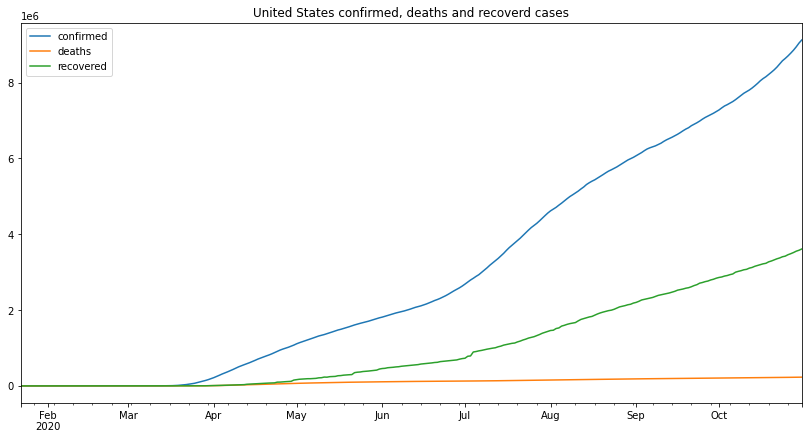

In [12]:
us_df.plot(figsize=(14,7),title="United States confirmed, deaths and recoverd cases")

the number of confirmed cases started up slow until around April, it started to go up at a much faster rate and it kept that pace even during quarantine, in July the rate at which the cases are increasing got higher and the cases started increasing faster, this can be attributed to the recent protests and people's ignorance to the CDC guidelines.

deaths are the only cases that have had a continuously increasing rate, all the way from April the number of deaths is increasing at an increasing rate, until august where the increase rate is slower despite the higher number of cases.

when it comes to the recoveries, the recovery starts at the same time as the confirmed cases with a very unstable increase rate, the highest increase rate is also from around July which is surprising considering the rate of confirmed cases also went up around that time.

In [13]:
us_cases_outcome = (us_df.tail(1)['deaths'] + us_df.tail(1)['recovered'])[0]
us_outcome_perc = (us_cases_outcome / us_df.tail(1)['confirmed'] * 100)[0]
us_death_perc = (us_df.tail(1)['deaths'] / us_cases_outcome * 100)[0]
us_reco_perc = (us_df.tail(1)['recovered'] / us_cases_outcome * 100)[0]
us_active = (us_df.tail(1)['confirmed'] - us_cases_outcome)[0]

print(f"Number of cases which had an outcome: {us_cases_outcome}")
print(f"percentage of cases that had an outcome: {round(us_outcome_perc, 2)}%")
print(f"Deaths rate: {round(us_death_perc, 2)}%")
print(f"Recovery rate: {round(us_reco_perc, 2)}%")
print(f"Currently Active cases: {us_active}")

Number of cases which had an outcome: 3843026
percentage of cases that had an outcome: 42.11%
Deaths rate: 6.0%
Recovery rate: 94.0%
Currently Active cases: 5282456


the percentage of cases that had an outcome is just 38.06% of the total cases, which is very low, the other 61.4 of the cases which are not accounted for have probably not been released officially by the government, however, the recovery rate is high at 91.79% while the death rate is at 8.21%

number of currently active cases is still very high, and it's going up if the current increase rates are to be quoted.

# Modeling

for modeling and predicting the number of cases in the upcoming days the following types of models will be implemented:

- Bidrectional Long Short Term Memory (BiLSTM)
> LSTMs' are known and widely used in time sensitive data where a variable is increaing with time depending on the values from prior days. 
- Autoregressive Integrated Moving Average (ARIMA)
> models the next step in the sequence as a linear function of the observations and resiudal errors at prior time steps.
- Holt's Exponential Smoothing (HES)
> also referred to as holt's linear trend model or double exponential smoothing, models the next time step as an exponentially weighted linear function of observations at prior time step taking into account trends (the only difference from SES)

each country will have a total number of 3 models and the results will be compared accordingly.

our data is in a daily format and we want to predict n days at a time so we will take out the last n days and use them to test and predict outcomes it 2 weeks time.

In [14]:
n_input = 10  # number of steps
n_features = 1 # number of y 

# prepare required input data
def prepare_data(df):
    # drop rows with zeros
    df = df[(df.T != 0).any()]
    
    num_days = len(df) - n_input
    train = df.iloc[:num_days]
    test = df.iloc[num_days:]
    
    # normalize the data according to largest value
    scaler = MinMaxScaler()
    scaler.fit(train) # find max value

    scaled_train = scaler.transform(train) # divide every point by max value
    scaled_test = scaler.transform(test)
    
    # feed in batches [t1,t2,t3] --> t4 
    generator = TimeseriesGenerator(scaled_train,scaled_train,length = n_input,batch_size = 1)
    validation_set = np.append(scaled_train[55],scaled_test) # random tbh
    validation_set = validation_set.reshape(n_input + 1,1)
    validation_gen = TimeseriesGenerator(validation_set,validation_set,length = n_input,batch_size = 1)
    
    return scaler, train, test, scaled_train, scaled_test, generator, validation_gen

## Building the models

In [15]:
# create, train and return LSTM model
def train_lstm_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(84, recurrent_dropout = 0, unroll = False, return_sequences = True, use_bias = True, input_shape = (n_input,n_features))))
    model.add(LSTM(84, recurrent_dropout = 0.1, use_bias = True, return_sequences = True,))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(84, activation = "relu"))
    model.add(Dense(units = 1))
    
    # compile model
    model.compile(loss = 'mae', optimizer = Adam(1e-5))
    
    # finally train the model using generators
    model.fit_generator(generator,validation_data = validation_gen, epochs = 100, steps_per_epoch = round(len(train) / n_input), verbose = 0)
    
    return model

In [16]:
# predict, rescale and append needed columns to final data frame
def lstm_predict(model):
    # holding predictions
    test_prediction = []

    # last n points from training set
    first_eval_batch = scaled_train[-n_input:]
    current_batch = first_eval_batch.reshape(1,n_input,n_features)
    
    # predict first x days from testing data 
    for i in range(len(test) + n_input):
        current_pred = model.predict(current_batch)[0]
        test_prediction.append(current_pred)
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    # inverse scaled data
    true_prediction = scaler.inverse_transform(test_prediction)

    MAPE, accuracy, sum_errs, interval, stdev, df_forecast = gen_metrics(true_prediction)

    return MAPE, accuracy, sum_errs, interval, stdev, df_forecast

# plotting model losses
def plot_lstm_losses(model):
    pd.DataFrame(model.history.history).plot(figsize = (14,7), title = "loss vs epochs curve")

In [17]:
'''
incrementally trained ARIMA:
    - train with original train data
    - predict the next value
    - appened the prediction value to the training data
    - repeat training and appending for n times (days in this case)
    
    this incremental technique significantly improves the accuracy
    by always using all data up to previous day for predeicting next value
    unlike predecting multiple values at the same time which is not incremeital.
    
    PARAMETERS:
    p: autoregressive(AR) order
    d: order of differencing
    q: moving average(MA) order
'''

def arima_predict(p: int, d: int, q: int):
    values = [x for x in train.values]
    predictions = []
    for t in range(len(test) + n_input): # the number of testing days + the future days to predict 
        model = ARIMA(values, order = (p,d,q))
        model_fit = model.fit()
        fcast = model_fit.forecast()
        predictions.append(fcast[0][0])
        values.append(fcast[0])
    
    MAPE, accuracy, sum_errs, interval, stdev, df_forecast = gen_metrics(predictions)
    
    return MAPE, accuracy, sum_errs, interval, stdev, df_forecast

In [18]:
'''
incremental Holt's (Method) Exponential Smoothing
    - trained the same way as above arima
'''
def hes_predict():   
    values = [x for x in train.values]
    predictions = []
    for t in range(len(test) + n_input): # the number of testing days + the future days to predict 
        model = Holt(values)
        model_fit = model.fit()
        fcast = model_fit.predict()
        predictions.append(fcast[0])
        values.append(fcast[0])
        
    MAPE, accuracy, sum_errs, interval, stdev, df_forecast = gen_metrics(predictions)
    
    return MAPE, accuracy, sum_errs, interval, stdev, df_forecast

In [19]:
# generate a dataframe with given range
def get_range_df(start: str, end: str, df):
    target_df = df.loc[pd.to_datetime(start, format='%Y-%m-%d'):pd.to_datetime(end, format='%Y-%m-%d')]
    return target_df

In [20]:
# fill na values in a range predicted data frame with actual values from the original dataframe
def pad_range_df(df, original_df):
    df['confirmed'] = df.confirmed.fillna(original_df['confirmed']) # fill confirmed Na
    
    # fill daily na
    daily_act = []
    daily_df = pd.DataFrame(columns = ["daily"], index = df[n_input:].index)
    
    for num in range(n_input - 1, (n_input * 2) - 1):
        daily_act.append(df["confirmed"].iloc[num + 1] - df["confirmed"].iloc[num])
    
    daily_df['daily'] = daily_act
    df['daily'] = df.daily.fillna(daily_df['daily'])
    return df

In [21]:
# generate metrics and final df
def gen_metrics(pred):
    # create time series
    time_series_array = test.index
    for k in range(0, n_input):
        time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))

    # create time series data frame
    df_forecast = pd.DataFrame(columns = ["confirmed","confirmed_predicted"],index = time_series_array)
    
    # append confirmed and predicted confirmed
    df_forecast.loc[:,"confirmed_predicted"] = pred
    df_forecast.loc[:,"confirmed"] = test["confirmed"]
    
    # create and append daily cases (for both actual and predicted)
    daily_act = []
    daily_pred = []
    
    #actual
    daily_act.append(abs(df_forecast["confirmed"].iloc[1] - train["confirmed"].iloc[-1]))
    for num in range((n_input * 2) - 1):
        daily_act.append(df_forecast["confirmed"].iloc[num + 1] - df_forecast["confirmed"].iloc[num])
    
    # predicted
    daily_pred.append(df_forecast["confirmed_predicted"].iloc[1] - train["confirmed"].iloc[-1])
    for num in range((n_input * 2) - 1):
        daily_pred.append(df_forecast["confirmed_predicted"].iloc[num + 1] - df_forecast["confirmed_predicted"].iloc[num])
    
    df_forecast["daily"] = daily_act
    df_forecast["daily_predicted"] = daily_pred
    
    # calculate mean absolute percentage error
    MAPE = np.mean(np.abs(np.array(df_forecast["confirmed"][:n_input]) - np.array(df_forecast["confirmed_predicted"][:n_input])) / np.array(df_forecast["confirmed"][:n_input]))

    accuracy = round((1 - MAPE) * 100, 2)

    # the error rate
    sum_errs = np.sum((np.array(df_forecast["confirmed"][:n_input]) - np.array(df_forecast["confirmed_predicted"][:n_input])) ** 2)

    # error standard deviation
    stdev = np.sqrt(1 / (n_input - 2) * sum_errs)

    # calculate prediction interval
    interval = 1.96 * stdev

    # append the min and max cases to final df
    df_forecast["confirm_min"] = df_forecast["confirmed_predicted"] - interval
    df_forecast["confirm_max"] = df_forecast["confirmed_predicted"] + interval
    
    # round all df values to 0 decimal points
    df_forecast = df_forecast.round() 
    
    return MAPE, accuracy, sum_errs, interval, stdev, df_forecast

In [22]:
# print metrics for given county
def print_metrics(mape, accuracy, errs, interval, std, model_type):
    m_str = "LSTM" if model_type == 0 else "ARIMA" if model_type == 1 else "HES"
    print(f"{m_str} MAPE: {round(mape * 100, 2)}%")
    print(f"{m_str} accuracy: {accuracy}%")
    print(f"{m_str} sum of errors: {round(errs)}")
    print(f"{m_str} prediction interval: {round(interval)}")
    print(f"{m_str} standard deviation: {std}")

In [23]:
# for plotting the range of predicetions
def plot_results(df, country, algo):
    fig, (ax1, ax2) = plt.subplots(2, figsize = (14,20))
    ax1.set_title(f"{country} {algo} confirmed predictions")
    ax1.plot(df.index,df["confirmed"], label = "confirmed")
    ax1.plot(df.index,df["confirmed_predicted"], label = "confirmed_predicted")
    ax1.fill_between(df.index,df["confirm_min"], df["confirm_max"], color = "indigo",alpha = 0.09,label = "Confidence Interval")
    ax1.legend(loc = 2)
    
    ax2.set_title(f"{country} {algo} confirmed daily predictions")
    ax2.plot(df.index, df["daily"], label = "daily")
    ax2.plot(df.index, df["daily_predicted"], label = "daily_predicted")
    ax2.legend()
    
    import matplotlib.dates as mdates
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %-d'))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %-d'))
    fig.show()

## USA Predictions

In [24]:
# prepare the data

scaler, train, test, scaled_train, scaled_test, generator, validation_gen = prepare_data(us_con_series)

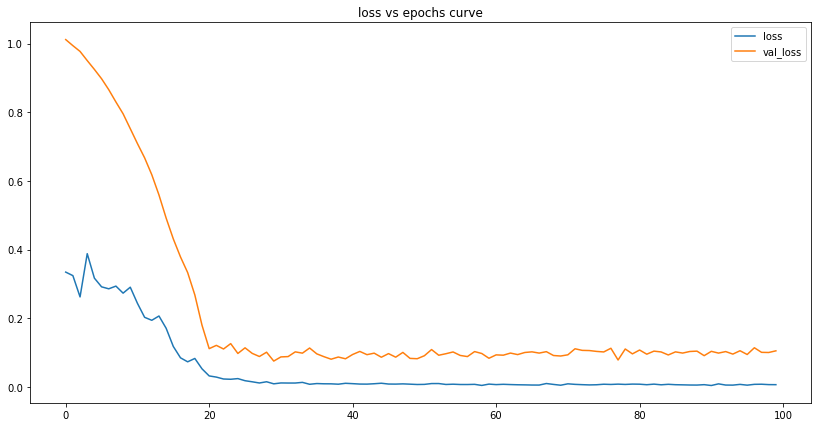

In [25]:
# train lstm model
us_lstm_model = train_lstm_model()

# plot lstm losses
plot_lstm_losses(us_lstm_model)

In [26]:
# Long short memory method
us_mape, us_accuracy, us_errs, us_interval, us_std, us_lstm_df = lstm_predict(us_lstm_model)

print_metrics(us_mape, us_accuracy, us_errs, us_interval, us_std, 0)

us_lstm_df

LSTM MAPE: 4.82%
LSTM accuracy: 95.18%
LSTM sum of errors: 2058053740601.0
LSTM prediction interval: 994121.0
LSTM standard deviation: 507204.8083122943


,confirmed,confirmed_predicted,daily,daily_predicted,confirm_min,confirm_max
2020-10-22,8409341.0,8205034.0,155448.0,-94666.0,7210912.0,9199155.0
2020-10-23,8493088.0,8242974.0,83747.0,37941.0,7248853.0,9237096.0
2020-10-24,8576818.0,8276551.0,83730.0,33577.0,7282430.0,9270672.0
2020-10-25,8637625.0,8306049.0,60807.0,29498.0,7311928.0,9300171.0
2020-10-26,8704423.0,8331693.0,66798.0,25644.0,7337572.0,9325815.0
2020-10-27,8778055.0,8354006.0,73632.0,22313.0,7359885.0,9348127.0
2020-10-28,8856413.0,8373629.0,78358.0,19623.0,7379508.0,9367750.0
2020-10-29,8944934.0,8392144.0,88521.0,18515.0,7398022.0,9386265.0
2020-10-30,9044255.0,8408804.0,99321.0,16660.0,7414683.0,9402925.0
2020-10-31,9125482.0,8423733.0,81227.0,14929.0,7429611.0,9417854.0


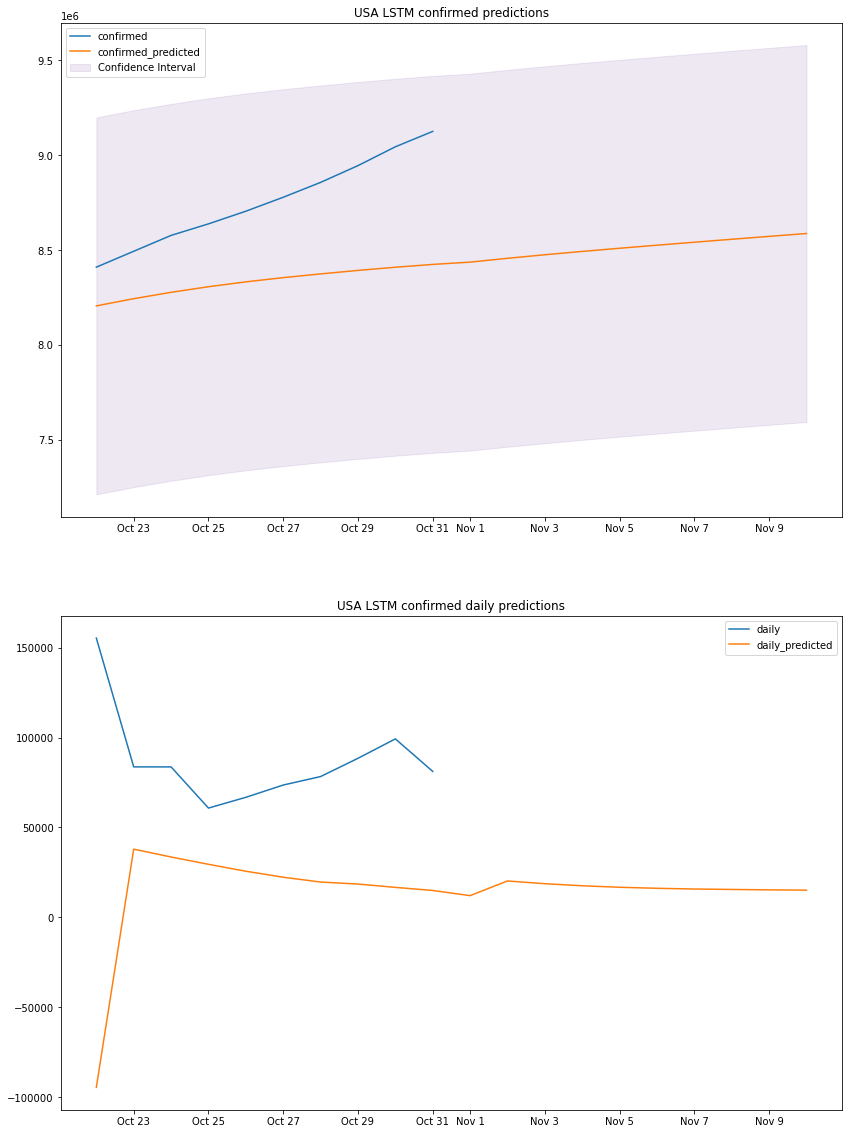

In [27]:
plot_results(us_lstm_df, "USA", "LSTM")

In [28]:
# Auto Regressive Integrated Moving Average 

us_mape, us_accuracy, us_errs, us_interval, us_std, us_arima_df = arima_predict(8, 1, 1)

print_metrics(us_mape, us_accuracy, us_errs, us_interval, us_std, 1)

us_arima_df

ARIMA MAPE: 0.72%
ARIMA accuracy: 99.28%
ARIMA sum of errors: 58884624871.0
ARIMA prediction interval: 168156.0
ARIMA standard deviation: 85793.81160044324


,confirmed,confirmed_predicted,daily,daily_predicted,confirm_min,confirm_max
2020-10-22,8409341.0,8406811.0,155448.0,138884.0,8238655.0,8574967.0
2020-10-23,8493088.0,8476524.0,83747.0,69713.0,8308368.0,8644680.0
2020-10-24,8576818.0,8536828.0,83730.0,60303.0,8368672.0,8704983.0
2020-10-25,8637625.0,8593830.0,60807.0,57002.0,8425674.0,8761986.0
2020-10-26,8704423.0,8654269.0,66798.0,60439.0,8486113.0,8822425.0
2020-10-27,8778055.0,8716789.0,73632.0,62520.0,8548633.0,8884945.0
2020-10-28,8856413.0,8782879.0,78358.0,66089.0,8614723.0,8951034.0
2020-10-29,8944934.0,8853301.0,88521.0,70422.0,8685145.0,9021457.0
2020-10-30,9044255.0,8921778.0,99321.0,68477.0,8753622.0,9089933.0
2020-10-31,9125482.0,8984015.0,81227.0,62237.0,8815859.0,9152170.0


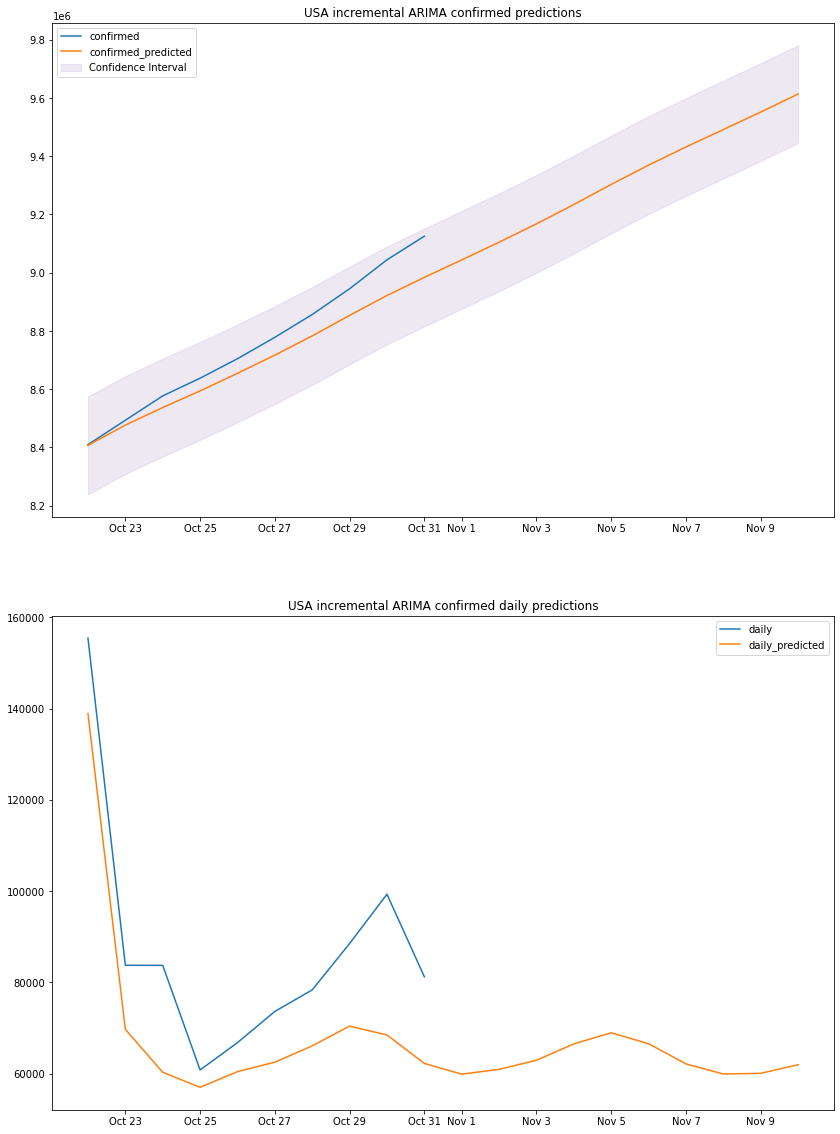

In [29]:
plot_results(us_arima_df, "USA", "incremental ARIMA")

In [30]:
# Holts Exponential Smoothing
us_mape, us_accuracy, us_errs, us_interval, us_std, us_hes_df = hes_predict()

print_metrics(us_mape, us_accuracy, us_errs, us_interval, us_std, 2)

us_hes_df

HES MAPE: 0.83%
HES accuracy: 99.17%
HES sum of errors: 75839516016.0
HES prediction interval: 190835.0
HES standard deviation: 97364.98088117794


,confirmed,confirmed_predicted,daily,daily_predicted,confirm_min,confirm_max
2020-10-22,8409341.0,8400415.0,155448.0,125551.0,8209580.0,8591251.0
2020-10-23,8493088.0,8463191.0,83747.0,62776.0,8272356.0,8654027.0
2020-10-24,8576818.0,8525967.0,83730.0,62776.0,8335132.0,8716802.0
2020-10-25,8637625.0,8588743.0,60807.0,62776.0,8397907.0,8779578.0
2020-10-26,8704423.0,8651518.0,66798.0,62776.0,8460683.0,8842354.0
2020-10-27,8778055.0,8714294.0,73632.0,62776.0,8523459.0,8905129.0
2020-10-28,8856413.0,8777070.0,78358.0,62776.0,8586234.0,8967905.0
2020-10-29,8944934.0,8839845.0,88521.0,62776.0,8649010.0,9030681.0
2020-10-30,9044255.0,8902621.0,99321.0,62776.0,8711786.0,9093457.0
2020-10-31,9125482.0,8965397.0,81227.0,62776.0,8774562.0,9156232.0


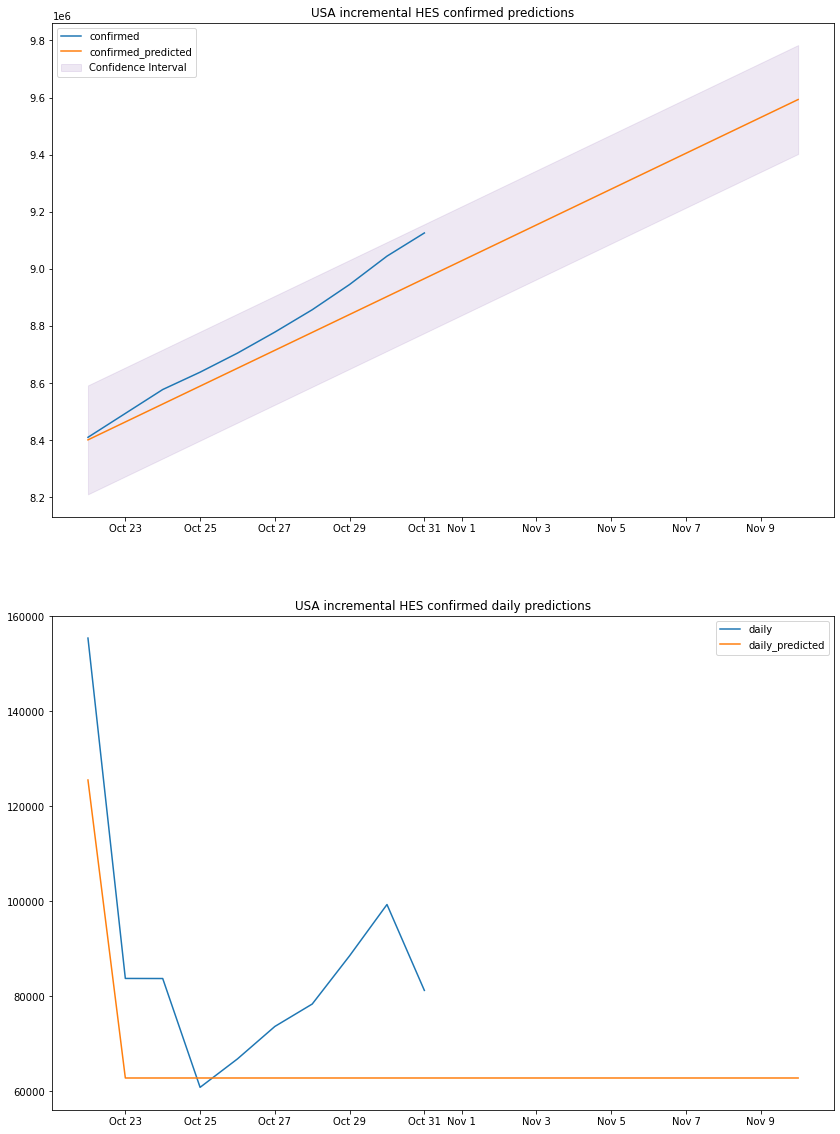

In [31]:
plot_results(us_hes_df, "USA", "incremental HES")

# Effectiveness of mandated lockdown
was the US lockdown effective in reducing the cases?  
the US started their lockdwon in 2020-03-17 and it was ended by the erupting protests.
tracking the lockdown might be tricky in the US at least because each state started their lockdown at their own pace and there was no federally mandated lockdown while some other states never went into lockdowns, taking that into account we will consider the end of the lockdown to be the end of may which was the start of the Gorge Floyed protests.

**Time frame**
from 2020-03-17 until 2020-05-31

In [32]:
us_lockdown = get_range_df('2020-03-17', '2020-05-31', us_con_series)

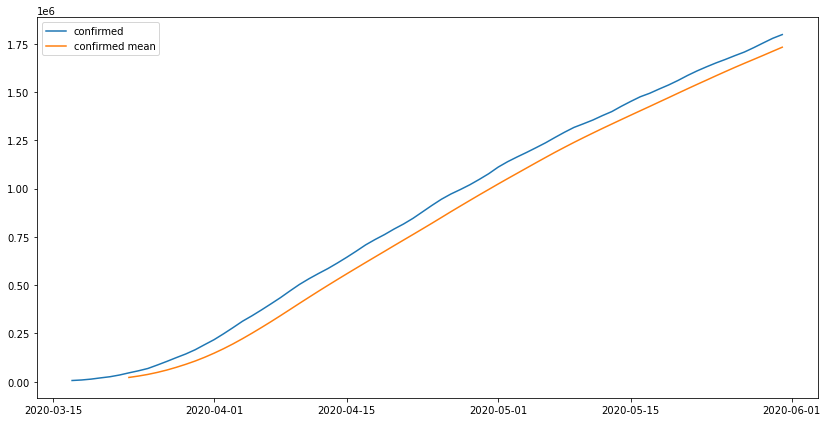

In [39]:
fig, ax = plt.subplots(1, figsize = (14,7))
ax.plot(us_lockdown.index, us_lockdown['confirmed'], label = 'confirmed')
ax.plot(us_lockdown.index, us_lockdown.rolling(7).mean(), label = 'confirmed mean')
ax.legend()

the actual values are above the moving average of each 7 days meaning the lockdown did not work as inteded and the number of cases was still very high when compared to the average of each 7 days, to make sure our previous model predictions are accurate we will use this period of time as a base and train the model on it and do prediction for the days after that which we already have the data on.
we will use the ARIMA model becuase the amount of data we have will not train a neural network ideally.

In [34]:
scaler, train, test, scaled_train, scaled_test, generator, validation_gen = prepare_data(us_lockdown)

In [35]:
# Auto Regressive Integrated Moving Average 

us_mape, us_accuracy, us_errs, us_interval, us_std, us_arima_df = arima_predict(8, 1, 1)

print_metrics(us_mape, us_accuracy, us_errs, us_interval, us_std, 1)

us_arima_df = pad_range_df(us_arima_df, us_con_series)

us_arima_df

ARIMA MAPE: 0.55%
ARIMA accuracy: 99.45%
ARIMA sum of errors: 1187672403.0
ARIMA prediction interval: 23881.0
ARIMA standard deviation: 12184.377305753513


,confirmed,confirmed_predicted,daily,daily_predicted,confirm_min,confirm_max
2020-05-22,1608604.0,1610272.0,44636.0,47633.0,1586391.0,1634154.0
2020-05-23,1629802.0,1632799.0,21198.0,22527.0,1608918.0,1656681.0
2020-05-24,1649916.0,1653311.0,20114.0,20511.0,1629429.0,1677192.0
2020-05-25,1668235.0,1674419.0,18319.0,21108.0,1650537.0,1698300.0
2020-05-26,1687761.0,1695924.0,19526.0,21505.0,1672042.0,1719805.0
2020-05-27,1706351.0,1719538.0,18590.0,23614.0,1695657.0,1743419.0
2020-05-28,1729299.0,1744487.0,22948.0,24949.0,1720606.0,1768369.0
2020-05-29,1753651.0,1768770.0,24352.0,24283.0,1744889.0,1792652.0
2020-05-30,1777495.0,1791120.0,23844.0,22350.0,1767239.0,1815002.0
2020-05-31,1796670.0,1812184.0,19175.0,21064.0,1788303.0,1836066.0


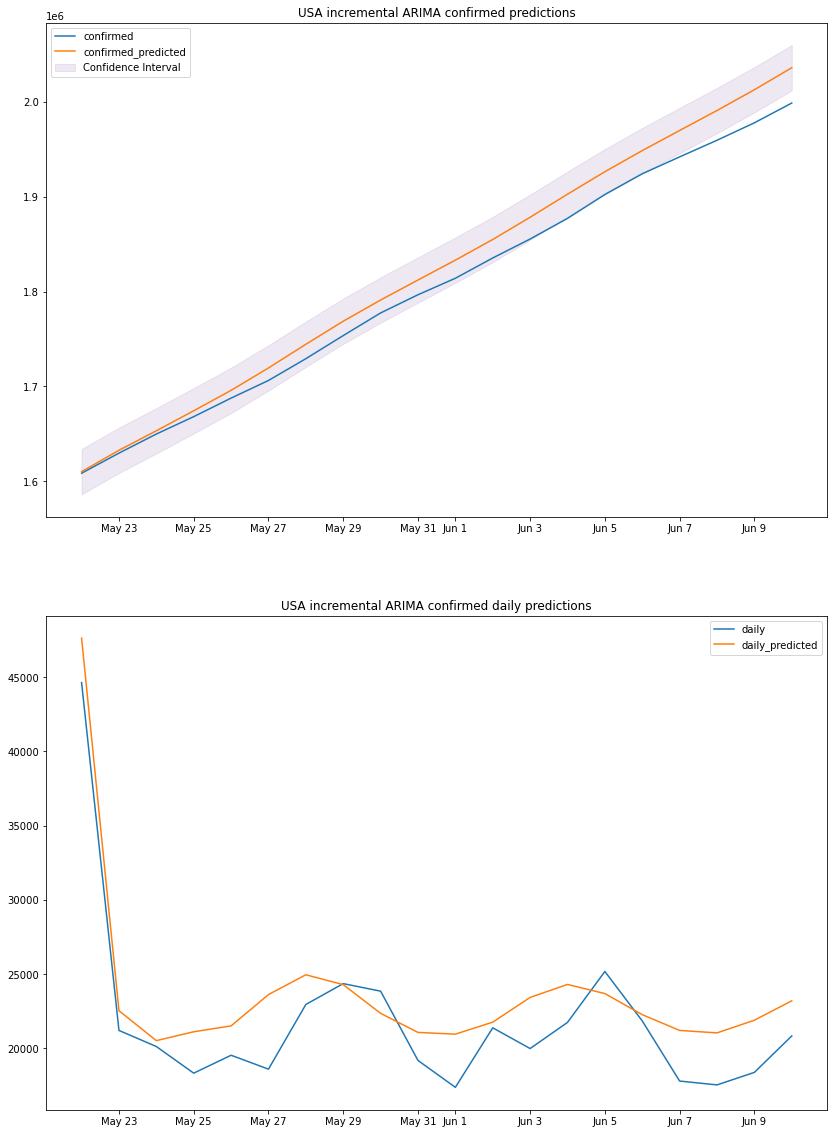

In [36]:
plot_results(us_arima_df, "USA", "incremental ARIMA")

we can see that the predicted totals and predicted daily cases are fairly accurate thus our previous predictions can be taken with some degree of accuracy, and might be used for making decisions.

# Conclusion

from all the graphs, functions and numbers above we can come to a simple conclusion that is, there is no single model that will perform best in all scenario even when the data is very similar (in trend not numbers), each model was best for a specific country and wasn’t so far behind in the others for example the HES model is the most accurate with the South Korean dataset but is almost the same as the ARIMA model in Italy.

**whats the difference between ARIMA and HES?**  
ARIMA uses a non-linear function for coefficient calculations, that’s why the graph does curve sometimes (Italy) while HES is a pure linear method that uses a linear function and is always a straight line

**Considering LSTM is usually the least accurate, is it worth the training time?**  
here may be, however, deep learning has its place among machine learning algorithms and can perform tasks these other functions could never, also the LSTM model always predicts a wider interval compared to the other 2, in a practical scenario where range is important the other 2 models will not be ideal because their results are limited by the original value and don’t spread as much, the LSTM model could provide better estimates. 

**ARIMA or HES?**  
HES, because it takes much less time to train and is as accurate or even more accurate sometimes.